# 📓  03_geolocation_processing.ipynb (IP to Country)

In [ ]:
# # Geolocation Processing
# Merge IP addresses with country mapping


# ## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# ## 2. Load Data
# Load cleaned e-commerce data
fraud_data = pd.read_csv('../data/processed/fraud_data_cleaned.csv')
print(f"📊 Fraud data shape: {fraud_data.shape}")

# Load IP to country mapping
ip_country = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
print(f"📊 IP mapping shape: {ip_country.shape}")
print("\n📋 IP mapping sample:")
ip_country.head()

📊 Fraud data shape: (151112, 13)
📊 IP mapping shape: (138846, 3)

📋 IP mapping sample:


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [3]:
# ## 3. Prepare IP Addresses
print("🔧 Preparing IP addresses...")

# Convert IP to integer if not already done
if 'ip_address_int' not in fraud_data.columns:
    fraud_data['ip_address_int'] = fraud_data['ip_address'].astype(float).astype(int)

# Ensure IP mapping columns are integers
ip_country['lower_bound'] = ip_country['lower_bound_ip_address'].astype(int)
ip_country['upper_bound'] = ip_country['upper_bound_ip_address'].astype(int)

print(f"✅ IP addresses prepared:")
print(f"   - Min IP: {fraud_data['ip_address_int'].min()}")
print(f"   - Max IP: {fraud_data['ip_address_int'].max()}")
print(f"   - IP ranges in mapping: {len(ip_country)}")

🔧 Preparing IP addresses...
✅ IP addresses prepared:
   - Min IP: 52093
   - Max IP: 4294850499
   - IP ranges in mapping: 138846


In [4]:
# ## 4. Merge IP with Country
print("🌍 Merging IP addresses with countries...")

# Sort both datasets for merge_asof
fraud_sorted = fraud_data.sort_values('ip_address_int').reset_index(drop=True)
ip_sorted = ip_country.sort_values('lower_bound').reset_index(drop=True)

# Merge using merge_asof (fast range lookup)
merged_df = pd.merge_asof(
    fraud_sorted,
    ip_sorted[['lower_bound', 'upper_bound', 'country']],
    left_on='ip_address_int',
    right_on='lower_bound',
    direction='backward'
)

# Keep only valid matches (IP within range)
mask = (merged_df['ip_address_int'] >= merged_df['lower_bound']) & \
       (merged_df['ip_address_int'] <= merged_df['upper_bound'])
merged_df = merged_df[mask].copy()

print(f"✅ Merge completed:")
print(f"   - Total transactions: {len(merged_df)}")
print(f"   - Transactions with country: {len(merged_df)}")
print(f"   - Unique countries: {merged_df['country'].nunique()}")

# Check for unmapped IPs
if len(merged_df) < len(fraud_data):
    unmapped = len(fraud_data) - len(merged_df)
    print(f"⚠️  Warning: {unmapped} transactions could not be mapped to country")


🌍 Merging IP addresses with countries...
✅ Merge completed:
   - Total transactions: 129146
   - Transactions with country: 129146
   - Unique countries: 181
⚠️  Warning: 21966 transactions could not be mapped to country


In [5]:
# ## 5. Analyze Fraud by Country
print("📊 Analyzing fraud patterns by country...")

# Calculate fraud statistics by country
country_stats = merged_df.groupby('country').agg(
    total_transactions=('class', 'count'),
    fraud_count=('class', 'sum'),
    fraud_rate=('class', 'mean'),
    avg_purchase_value=('purchase_value', 'mean'),
    avg_age=('age', 'mean')
).sort_values('fraud_rate', ascending=False)

print("\n🏆 Top 10 Countries by Fraud Rate:")
print(country_stats.head(10))

📊 Analyzing fraud patterns by country...

🏆 Top 10 Countries by Fraud Rate:
                       total_transactions  fraud_count  fraud_rate  \
country                                                              
Turkmenistan                            1            1    1.000000   
Namibia                                23           10    0.434783   
Sri Lanka                              31           13    0.419355   
Luxembourg                             72           28    0.388889   
Virgin Islands (U.S.)                   3            1    0.333333   
Ecuador                               106           28    0.264151   
Tunisia                               118           31    0.262712   
Peru                                  119           31    0.260504   
Bolivia                                53           13    0.245283   
Kuwait                                 90           21    0.233333   

                       avg_purchase_value    avg_age  
country                     

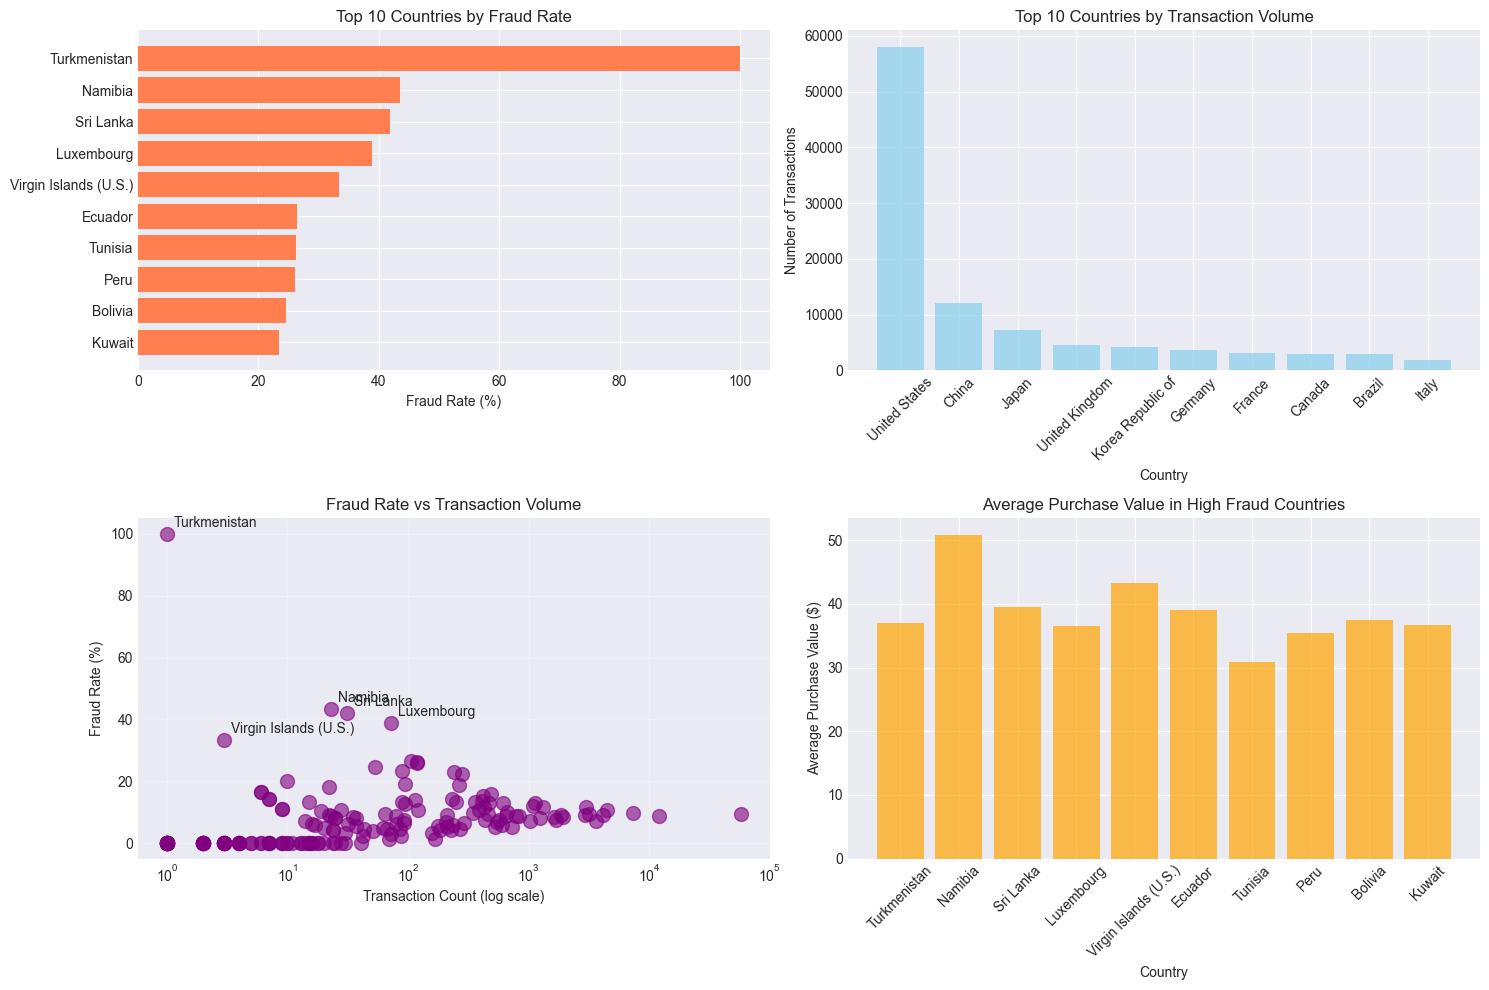

In [6]:
# ## 6. Visualize Country Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Top 10 countries by fraud rate
top_countries = country_stats.head(10).reset_index()
bars1 = axes[0,0].barh(top_countries['country'], top_countries['fraud_rate'] * 100, 
                      color='coral')
axes[0,0].set_title('Top 10 Countries by Fraud Rate')
axes[0,0].set_xlabel('Fraud Rate (%)')
axes[0,0].invert_yaxis()

# 2. Top 10 countries by transaction volume
top_volume = country_stats.sort_values('total_transactions', ascending=False).head(10).reset_index()
axes[0,1].bar(top_volume['country'], top_volume['total_transactions'], 
             color='skyblue', alpha=0.7)
axes[0,1].set_title('Top 10 Countries by Transaction Volume')
axes[0,1].set_xlabel('Country')
axes[0,1].set_ylabel('Number of Transactions')
plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)

# 3. Fraud rate vs transaction volume scatter
axes[1,0].scatter(country_stats['total_transactions'], 
                 country_stats['fraud_rate'] * 100,
                 alpha=0.6, s=100, color='purple')
axes[1,0].set_xscale('log')  # Log scale for better visualization
axes[1,0].set_title('Fraud Rate vs Transaction Volume')
axes[1,0].set_xlabel('Transaction Count (log scale)')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].grid(True, alpha=0.3)

# Annotate outliers
for idx, row in country_stats[country_stats['fraud_rate'] > 0.3].iterrows():
    axes[1,0].annotate(idx, (row['total_transactions'], row['fraud_rate'] * 100),
                      xytext=(5, 5), textcoords='offset points')

# 4. Purchase value by country (top 10 fraud rate)
top_fraud = country_stats.head(10)
axes[1,1].bar(top_fraud.index, top_fraud['avg_purchase_value'], 
             color='orange', alpha=0.7)
axes[1,1].set_title('Average Purchase Value in High Fraud Countries')
axes[1,1].set_xlabel('Country')
axes[1,1].set_ylabel('Average Purchase Value ($)')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# ## 7. Create High-Risk Country Flag
print("🚩 Creating high-risk country flags...")

# Define high-risk countries (top 25% by fraud rate)
fraud_rate_threshold = country_stats['fraud_rate'].quantile(0.75)
high_risk_countries = country_stats[country_stats['fraud_rate'] > fraud_rate_threshold].index.tolist()

merged_df['is_high_risk_country'] = merged_df['country'].isin(high_risk_countries).astype(int)

print(f"📊 High-risk country analysis:")
print(f"   - Threshold fraud rate: {fraud_rate_threshold:.2%}")
print(f"   - Number of high-risk countries: {len(high_risk_countries)}")
print(f"   - High-risk country transactions: {merged_df['is_high_risk_country'].sum()}")
print(f"   - High-risk fraud rate: {merged_df[merged_df['is_high_risk_country'] == 1]['class'].mean():.2%}")
print(f"   - Low-risk fraud rate: {merged_df[merged_df['is_high_risk_country'] == 0]['class'].mean():.2%}")


🚩 Creating high-risk country flags...
📊 High-risk country analysis:
   - Threshold fraud rate: 9.79%
   - Number of high-risk countries: 45
   - High-risk country transactions: 17754
   - High-risk fraud rate: 12.93%
   - Low-risk fraud rate: 8.95%


In [8]:
# ## 8. Save Results
print("💾 Saving processed data...")

# Save merged data with countries
merged_df.to_csv('../data/processed/fraud_data_with_country.csv', index=False)

# Save country statistics
country_stats.to_csv('../data/processed/country_fraud_statistics.csv')

# Save high-risk country list
high_risk_df = pd.DataFrame({'country': high_risk_countries})
high_risk_df.to_csv('../data/processed/high_risk_countries.csv', index=False)

print("✅ Geolocation processing completed!")
print(f"\n📁 Saved files:")
print("   - fraud_data_with_country.csv")
print("   - country_fraud_statistics.csv")  
print("   - high_risk_countries.csv")


💾 Saving processed data...
✅ Geolocation processing completed!

📁 Saved files:
   - fraud_data_with_country.csv
   - country_fraud_statistics.csv
   - high_risk_countries.csv
